In [48]:
import cv2
import numpy as np
from ultralytics import YOLO
import time
import psutil


In [49]:
yolo_model = YOLO('yolov8n.pt')

vehicle_classes = [1, 2, 3, 5, 7]

In [123]:
def normalize_heatmap(heatmap):
    min_val = np.min(heatmap)
    max_val = np.max(heatmap)
    
    # Avoid division by zero if the heatmap is uniform
    if max_val - min_val > 0:
        normalized_heatmap = (heatmap - min_val) / (max_val - min_val) * 5
    else:
        normalized_heatmap = heatmap  # If all values are the same
    
    return normalized_heatmap

In [50]:
def detect_vehicles_yolo(frame):
    results = yolo_model.predict(frame, verbose=False) 
    vehicle_boxes = []
    
    for result in results:
        for bbox, cls_id, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
            if int(cls_id) in vehicle_classes and conf > 0.5:
                x1, y1, x2, y2 = map(int, bbox)
                vehicle_boxes.append([x1, y1, x2, y2])
    
    return vehicle_boxes

In [53]:
def generate_heatmap_yolo(frame, heatmap):
    vehicle_boxes = detect_vehicles_yolo(frame)
    
    for (x1, y1, x2, y2) in vehicle_boxes:
        heatmap[y1:y2, x1:x2] += 1
    
    return heatmap

In [79]:
def calculate_density_factor(heatmap):
    return np.sum(heatmap)

def dynamic_traffic_timer(density_factor, base_time=90, alpha=0.00001):
    return base_time * (1 + alpha * density_factor)


In [80]:
import math

In [134]:
def process_video(PATHH):
    cap = cv2.VideoCapture(PATHH)
    
    heatmap_yolo = np.zeros((480, 640), dtype=np.float32)
    
    inference_times_yolo = []
    
    cpu_usage_yolo = []
    mem_usage_yolo = []
    
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video")
        return
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, (640, 480))

        heatmap_yolo = generate_heatmap_yolo(frame_resized, heatmap_yolo)
    

    cap.release()

    # Calculate the density factor for the entire video
    density_factor = calculate_density_factor(normalize_heatmap(heatmap_yolo))
    
    # Calculate dynamic traffic timer based on the density factor
    dynamic_timer = dynamic_traffic_timer(density_factor)
    dynamic_timer=math.ceil(dynamic_timer)
    
    # Display the heatmap at the end of the video
    plt.figure()
    plt.title(f'Heatmap - {PATHH}')
    plt.imshow(heatmap_yolo, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

    return heatmap_yolo,dynamic_timer

In [135]:
video_paths = ['video.mp4', 'video2.mp4']  # Add your video paths here
dynamic_timers = []
heatmaps=[]

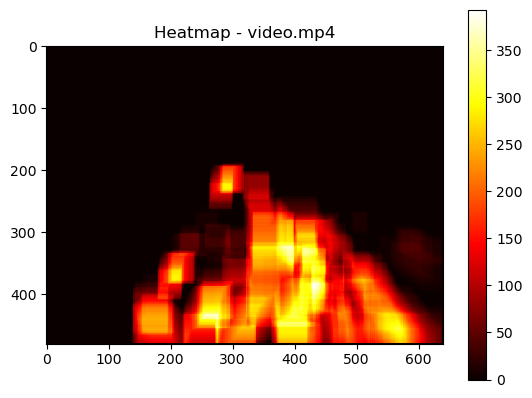

Dynamic Timer for video.mp4: 253 seconds


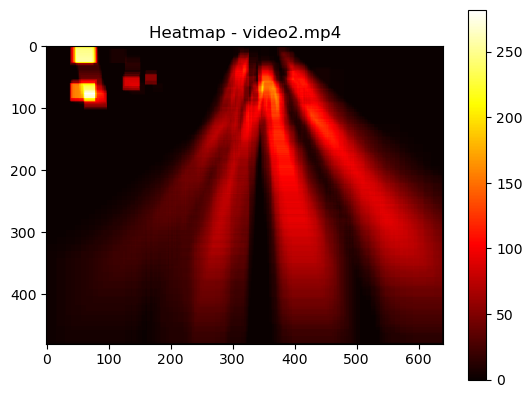

Dynamic Timer for video2.mp4: 228 seconds


In [136]:
for video_path in video_paths:
    heatmap,dynamic_timer = process_video(video_path)
    dynamic_timers.append(dynamic_timer)
    heatmaps.append(heatmap)
    print(f"Dynamic Timer for {video_path}: {dynamic_timer} seconds")